### Drzewa decyzyjne

In [1]:
import pandas as pd
train = pd.read_csv('data/ed-titanic-training.csv')
test = pd.read_csv('data/ed-titanic-test.csv')
train.head(3)

,Unnamed: 0,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,1,0,2,0,3,1,1,2,0,3
2,2,1,3,0,1,0,1,0,0,1,1,4


In [2]:
test.head(3)

,Unnamed: 0,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,2,0,0,2,0,1,1,1
1,1,3,0,2,0,0,0,0,2,0,3
2,2,2,1,3,0,1,2,0,1,1,1


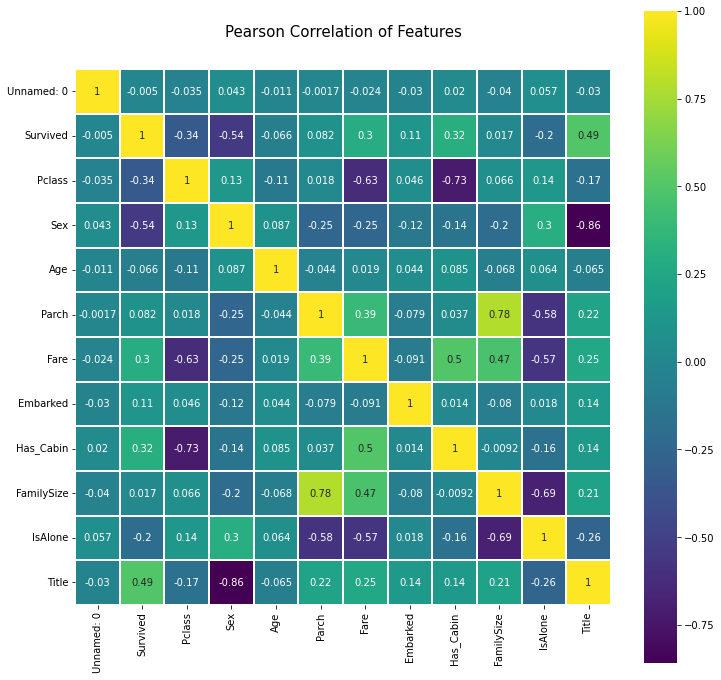

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

Najbardziej skorelowane ze sobą są ...

In [4]:
from collections import defaultdict
survivability = defaultdict(float)

for t,title in [(1,'Mr'),(2,'Master'),(3,'Mrs'),(4,'Miss'),(5,'Rare')]:
    ps = train[ train['Title'] == t]
    survived = ps[ ps['Survived'] == 1]
    survivability[title] = len(survived)/len(ps)

survivability

defaultdict(float,
            {'Mr': 0.15667311411992263,
             'Master': 0.575,
             'Mrs': 0.7936507936507936,
             'Miss': 0.7027027027027027,
             'Rare': 0.34782608695652173})

Widać że współczynnik przeżywalności dla osób z "wyższym" tytułem jest wyższy, jak również że współczynnik przeżywalności kobiet jest wyższy niż mężczyzn

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn import tree

x_train = train.loc[:, train.columns != 'Survived']
y_train = train.loc[:, train.columns == 'Survived']

for split in ['entropy', 'gini']:
    for depth in range(1, 11):
        decision_tree = tree.DecisionTreeClassifier(
            max_depth=depth, criterion=split)

        scores = cross_val_score(decision_tree, x_train, y_train, cv=10)
        print('split: %s\tdepth: %d\taccuracy: %0.2f\tstd: %0.2f' %
              (split, depth, scores.mean(), scores.std()))


split: entropy	depth: 1	accuracy: 0.78	std: 0.04
split: entropy	depth: 2	accuracy: 0.79	std: 0.04
split: entropy	depth: 3	accuracy: 0.83	std: 0.03
split: entropy	depth: 4	accuracy: 0.82	std: 0.04
split: entropy	depth: 5	accuracy: 0.82	std: 0.03
split: entropy	depth: 6	accuracy: 0.80	std: 0.03
split: entropy	depth: 7	accuracy: 0.79	std: 0.03
split: entropy	depth: 8	accuracy: 0.77	std: 0.03
split: entropy	depth: 9	accuracy: 0.77	std: 0.04
split: entropy	depth: 10	accuracy: 0.76	std: 0.04
split: gini	depth: 1	accuracy: 0.78	std: 0.04
split: gini	depth: 2	accuracy: 0.79	std: 0.04
split: gini	depth: 3	accuracy: 0.83	std: 0.03
split: gini	depth: 4	accuracy: 0.81	std: 0.04
split: gini	depth: 5	accuracy: 0.79	std: 0.04
split: gini	depth: 6	accuracy: 0.78	std: 0.04
split: gini	depth: 7	accuracy: 0.78	std: 0.05
split: gini	depth: 8	accuracy: 0.77	std: 0.04
split: gini	depth: 9	accuracy: 0.75	std: 0.04
split: gini	depth: 10	accuracy: 0.74	std: 0.05


Widać, że najlepsze wyniki osiągają drzewa o głębokości 3, niezależnie od kryterium podziału.

In [6]:
decision_tree = tree.DecisionTreeClassifier(max_depth = 3,criterion='entropy')
decision_tree.fit(x_train, y_train)

predictions = decision_tree.predict(test)
import numpy
numpy.savetxt('titanic_results.csv', predictions, delimiter=",", fmt='%d')

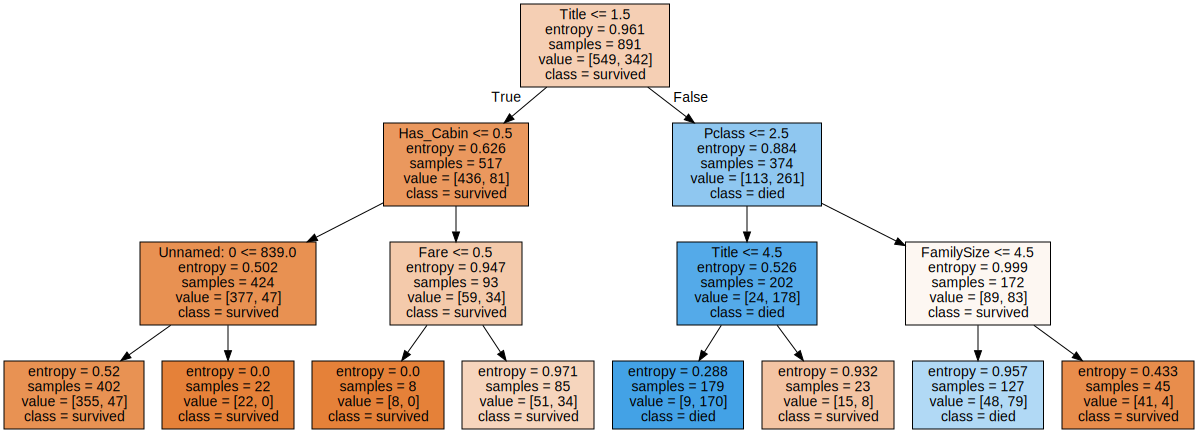

In [10]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                                feature_names=x_train.columns,  
                                class_names=['survived','died'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

TypeError: 'int' object is not subscriptable

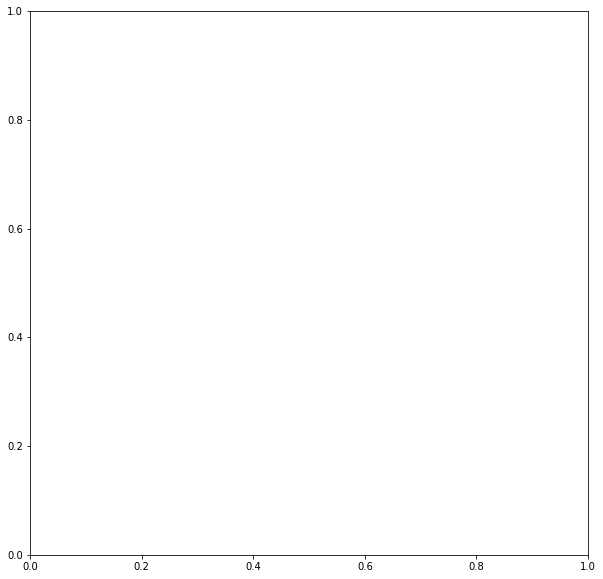

In [21]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(x_train, y_train, test_size=0.4, random_state=0)

results_e = []

for depth in range(1, 11):
    for min_leaf in range(1,6):
        d_tree =  tree.DecisionTreeClassifier(max_depth = depth, criterion='entropy', min_samples_leaf=min_leaf)
        d_tree.fit(X, y)
        predictions = d_tree.predict(X_test)
        score = f1_score(y_test, predictions)
        results_e += (depth, min_leaf,score)

results_g = []

for depth in range(1, 11):
    for min_leaf in range(1,6):
        d_tree =  tree.DecisionTreeClassifier(max_depth = depth, criterion='gini', min_samples_leaf=min_leaf)
        d_tree.fit(X, y)
        predictions = d_tree.predict(X_test)
        score = f1_score(y_test, predictions)
        results_g += (depth, min_leaf,score)

ds_e = map(lambda x: x[0], results_e)
lf_e = map(lambda x: x[1], results_e)
score_e = map(lambda y: y[2], results_e)
ds_g = map(lambda x: x[0], results_g)
lf_g = map(lambda x: x[1], results_g)
score_g = map(lambda y: y[2], results_g)

    
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(list(ds_e), list(score_e), c='red', label='entropy')
ax.scatter(list(ds_g), list(score_g), c='blue', label='gini')
ax.legend()
plt.xlabel('max depth')
plt.ylabel('score')
plt.show()
plt.close('all')

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(list(lf_e), list(score_e), c='red', label='entropy')
ax.scatter(list(lf_g), list(score_g), c='blue', label='gini')
ax.legend()
plt.xlabel('min leaf')
plt.ylabel('score')
plt.show()
plt.close('all')

